# DE1. Index order dependency pruning
Removing impossible dependencies based on index order and a # of books threshold for confirmation.

In [2]:
import pandas as pd
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import sys
sys.path.append('../src/')
import data_layer

In [3]:
NUM_BOOKS_EVIDENCE=1 # number of books that need to vote against a dependency

In [4]:
def get_first_page_for_concept(index, concept):
    vals = index.first_page.iloc[index.wiki_concept.values==concept].values
    return vals[0] if len(vals) else None

In [5]:
book_indices, wiki_concepts = data_layer.read_index_and_wiki_concepts()
n = wiki_concepts.shape[0]
print(str(n) + " wikipedia concepts in total")

1464 wikipedia concepts in total


In [6]:
n_books = len(book_indices.keys())
adj_by_book = np.tile(1, (n_books,n,n)) # 1 means "could be dependent"

def both_in_book(page1, page2): return page1 is not None and page2 is not None

for book_nr, book_index in enumerate(book_indices.values()):
    first_pages = [get_first_page_for_concept(book_index, concept) for concept in wiki_concepts]
    combinations = product(first_pages, first_pages)
    comparisons = [
        1 * (page1 > page2) if both_in_book(page1, page2) # if 1 is after 2 -> 1 could depend on 2
        else 2 # stands for unknown
        for (page1, page2) in combinations
    ]
    comparisons_2d = np.array(comparisons).reshape((n,n))
    np.fill_diagonal(comparisons_2d, 0) # concept cannot depend on itself
    adj_by_book[book_nr,:,:] = comparisons_2d

num_books = n_books - np.sum(adj_by_book==2,axis=0) # count num books for each pair
adj_by_book[adj_by_book==2] = 1 # reset this information
adj = np.sum(adj_by_book,axis=0) 

In [8]:
np.save("../dash/dash_textbooks/data/adj.npy",adj)
np.save("../dash/dash_textbooks/data/wiki_concepts.npy",wiki_concepts)

## Analytics

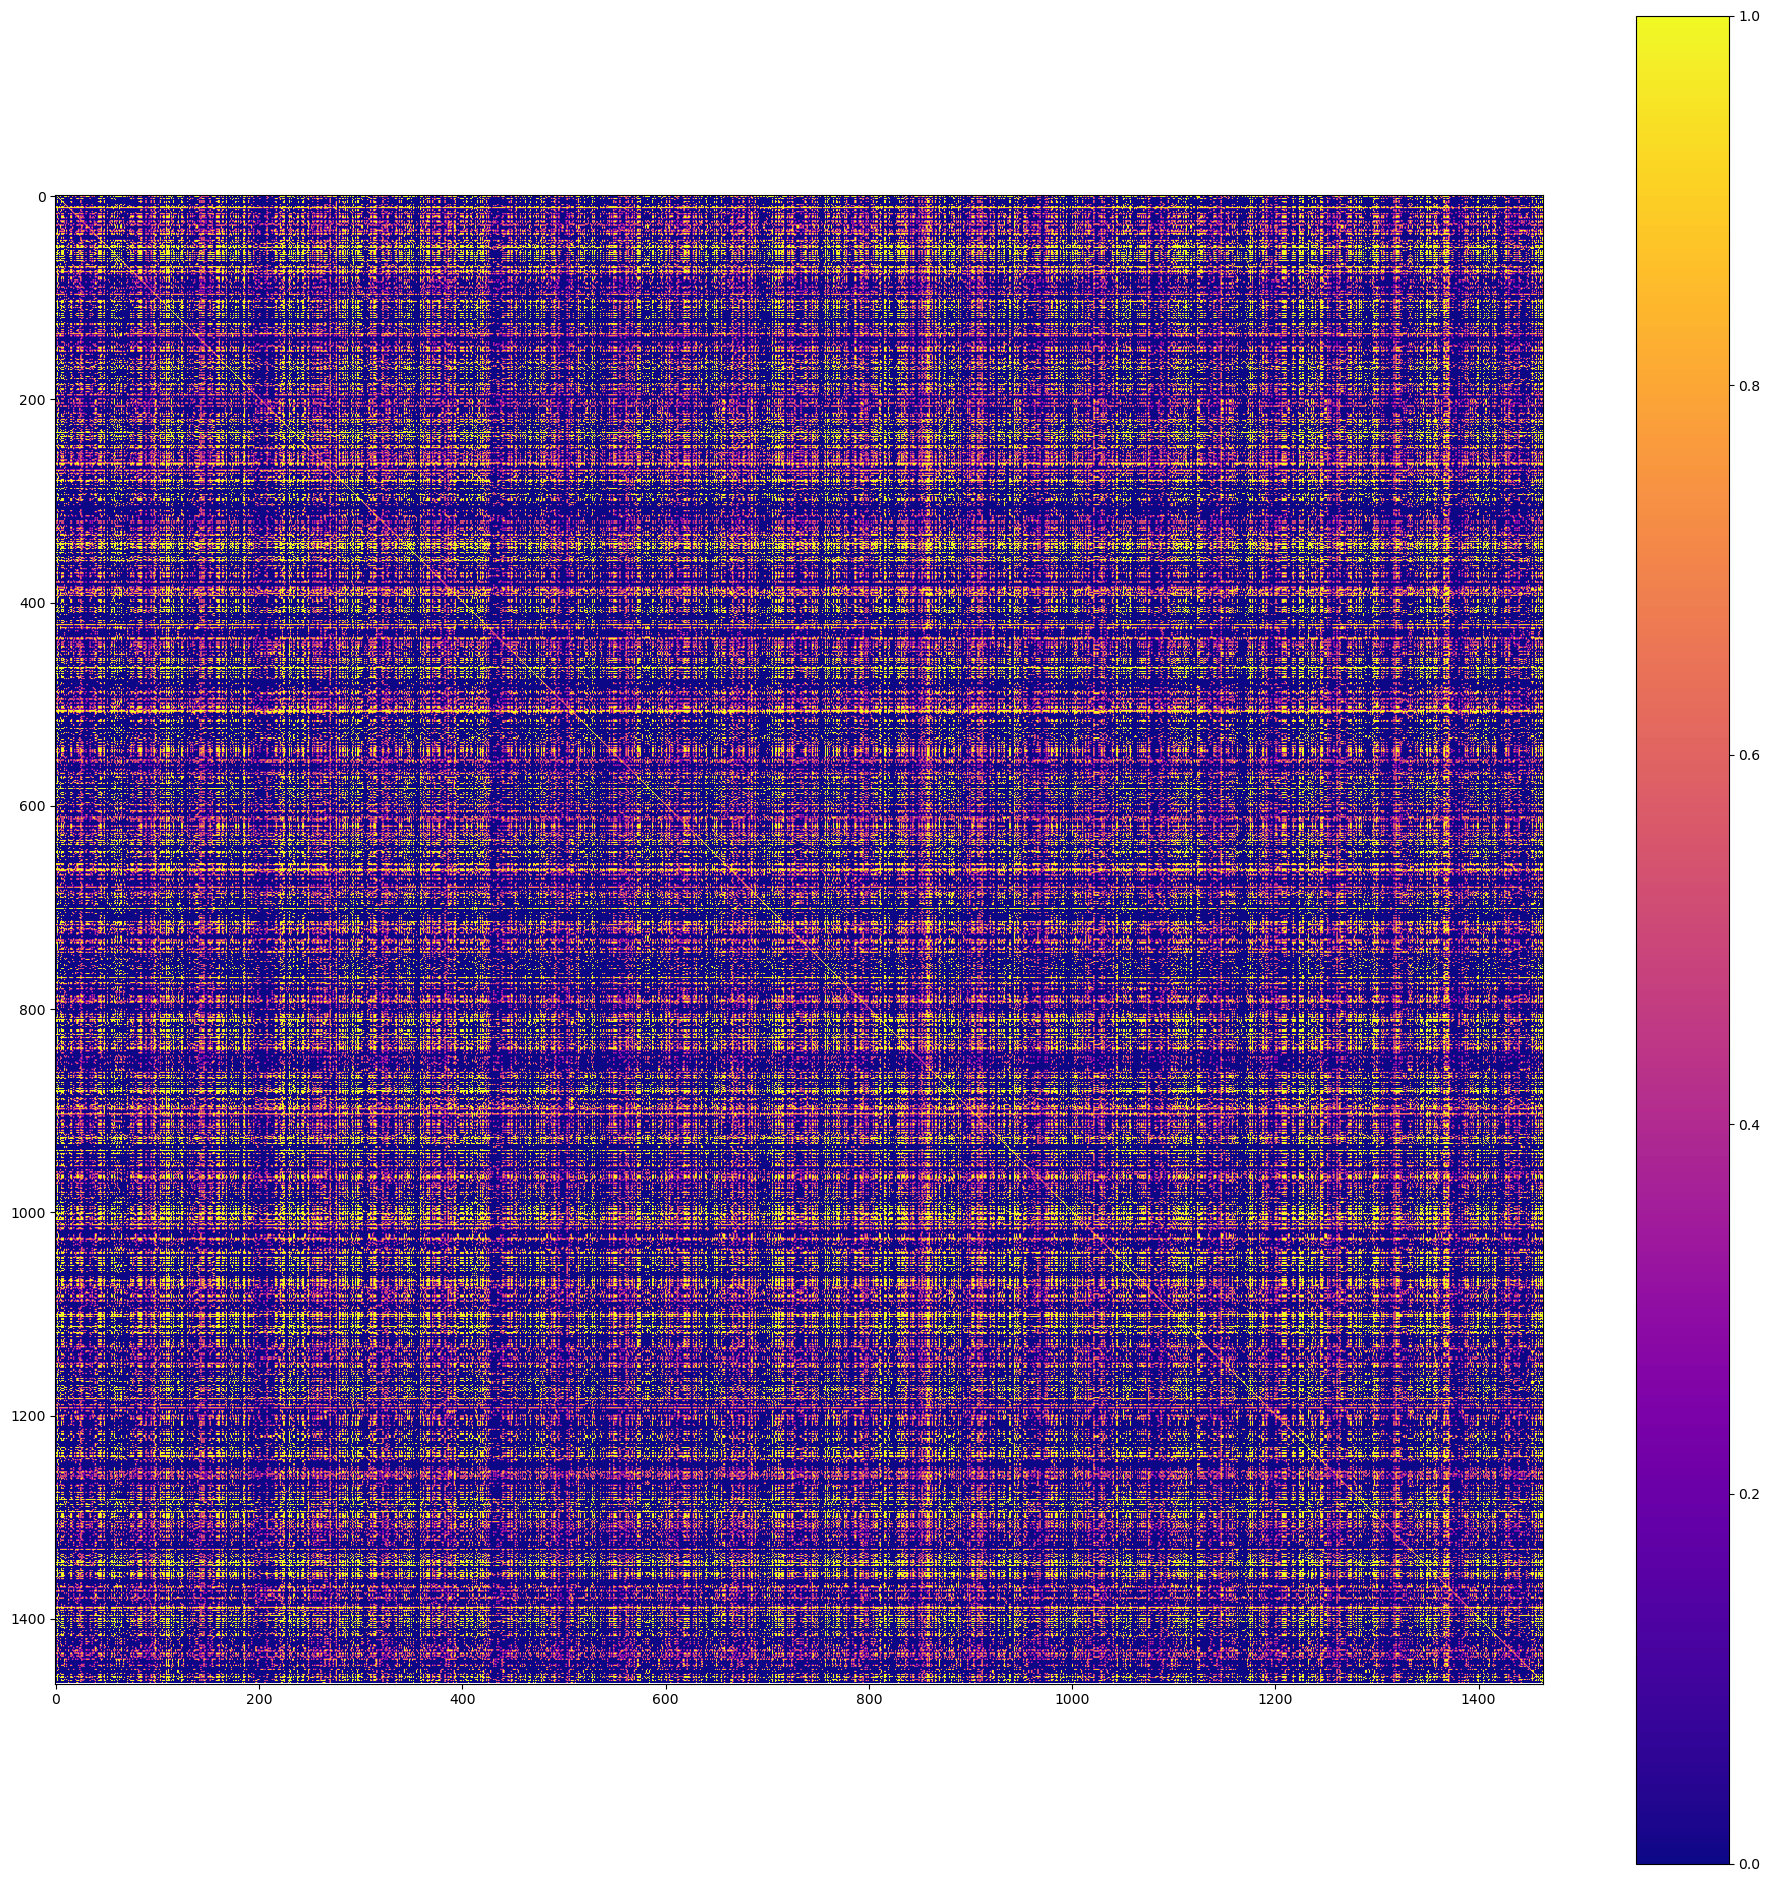

In [7]:
impossible_deps = 1*(adj <= (n_books-NUM_BOOKS_EVIDENCE))

fig, ax = plt.subplots(1, 1,figsize=(24,24))
im=ax.imshow(impossible_deps, cmap = "plasma")
fig.colorbar(im, ax=ax)
plt.savefig("../dat/wiki/adj_vis.png")

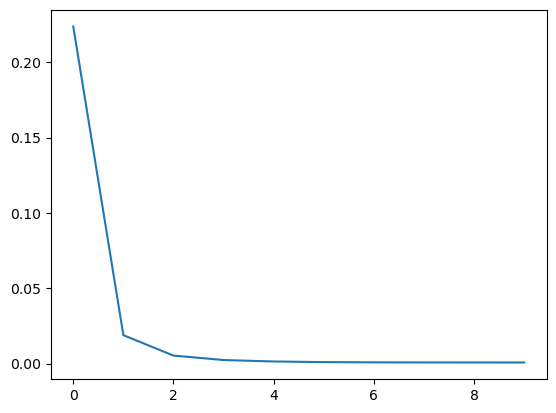

In [12]:
ratio_negative = [np.sum(1*(adj <= (n_books-threshold))) / n**2 for threshold in range(1,11)]
plt.plot(ratio_negative)
plt.show()

Median number of ruled out deps: 268


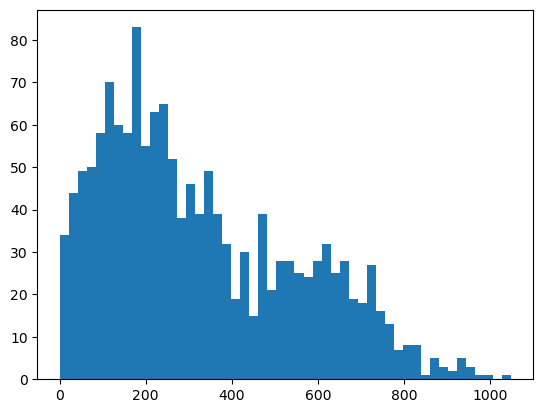

In [14]:
# histogram of dependencies ruled out per concept
num_outruled_per_concept = np.sum(impossible_deps, axis=0)
print(f"Median number of ruled out deps: {int(np.median(num_outruled_per_concept))}")
plt.hist(num_outruled_per_concept, bins=50)
plt.show()

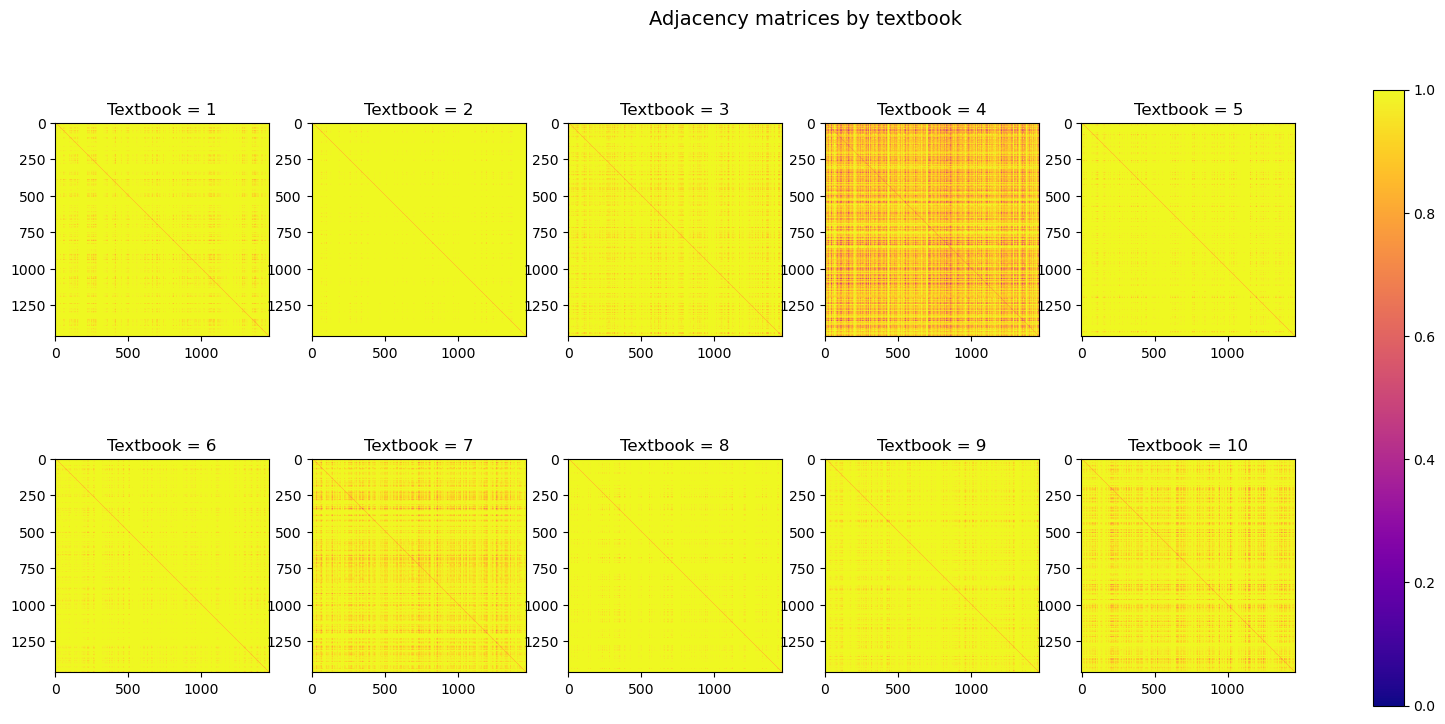

In [15]:
fig, axes = plt.subplots(2, 5,figsize=(20,8))

for i, ax in enumerate(axes.flatten()):
        im= ax.imshow(adj_by_book[i,:,:],cmap = "plasma")
        ax.title.set_text("Textbook = "+str(i+1))

fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle("Adjacency matrices by textbook",fontsize=14)
plt.show()

In [ ]:
# Quality is good but the size of the image is terribly huge

# import plotly.express as px
# fig = px.imshow(adj_by_book[:,:,:], binary_string=False, facet_col=0, facet_col_wrap=5,labels={'facet_col':'textbook'})
# fig.write_html("../fig/adj_matrices_textbook.html")
# fig.write_image("../fig/adj_matrices_textbook.pdf")
# fig.show()

In [16]:
adj_filtered_nbook_thr = np.tile(0, (n_books,n,n))

for nbook_thr in range(1,11):
    filter1 = (adj>=nbook_thr)
    filter2 = ((filter1+filter1.T)!=2)
    adj_filtered_nbook_thr[nbook_thr-1,:,:] = np.where(filter1  & filter2, adj, 0)


In [17]:
thr9 = adj_filtered_nbook_thr[8,:,:]
thr9[thr9>0]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

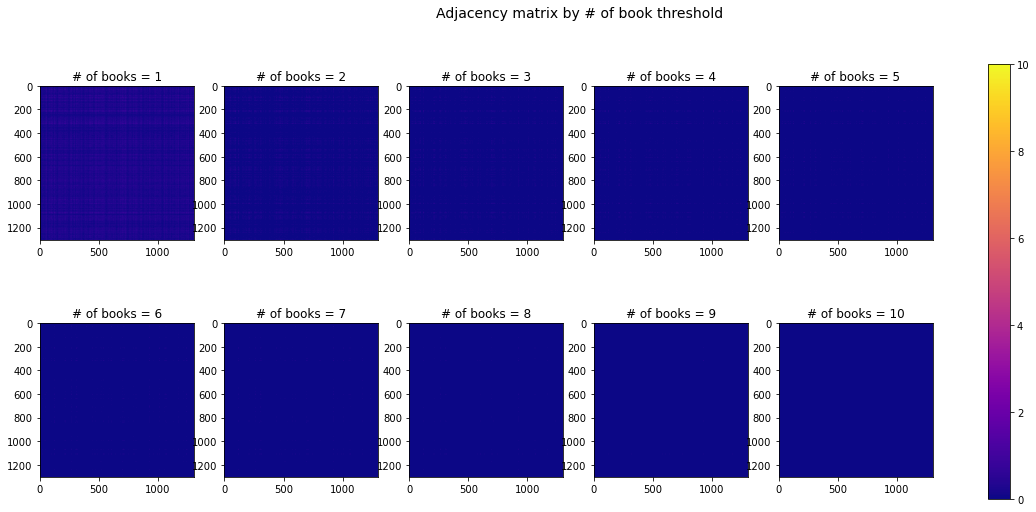

In [18]:
# not enough resolution to reflect all connections. Network illustrates the connections much better.
fig, axes = plt.subplots(2, 5,figsize=(20,8))

for i, ax in enumerate(axes.flatten()):
        im= ax.imshow(adj_filtered_nbook_thr[i,:,:], vmin=0, vmax=10, cmap = "plasma")
        ax.title.set_text("# of books = "+str(i+1))

fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle("Adjacency matrix by # of book threshold",fontsize=14)
plt.show()

In [1]:
# Quality is good but the size of the image is terribly huge

#fig = px.imshow(adj_filtered_nbook_thr[:,:,:], binary_string=False, facet_col=0, facet_col_wrap=5,labels={'facet_col':'# of book threshold'})

#for nbook_thr in range(1,11):
#    if nbook_thr <= 5:
#        fig.layout.annotations[nbook_thr + 4]['text'] = '# of book threshold = %d' %nbook_thr
#    else:
#        fig.layout.annotations[nbook_thr - 6]['text'] = '# of book threshold = %d' %nbook_thr

#fig.show()
#fig.write_html("../fig/adj_matrices_threshold.html")
#fig.write_image("../fig/adj_matrices_threshold.pdf", scale=0.3)